In [9]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import model_utils
import pickle

train_dataloader = pickle.load(open(os.path.join(os.getcwd(), '..', "data", "pytorch_data", 'train_dataloader.pkl'), 'rb'))
val_dataloader = pickle.load(open(os.path.join(os.getcwd(), '..', "data", "pytorch_data", 'val_dataloader.pkl'), 'rb'))
test_dataloader = pickle.load(open(os.path.join(os.getcwd(), '..', "data", "pytorch_data", 'test_dataloader.pkl'), 'rb'))

for team_input, player_input, ball_input, labels, mask in train_dataloader:
    print(f"Team input shape: {team_input.shape}")  # [batch_size, team_feature_dim]
    print(f"Player input shape: {player_input.shape}")  # [batch_size, player_feature_dim]
    print(f"Padded ball input shape: {ball_input.shape}")  # [batch_size, max_seq_len, ball_feature_dim]
    print(f"Mask shape: {mask.shape}")  # [batch_size, max_seq_len]
    print(f"Labels shape: {labels.shape}")  # [batch_size]
    break

Team input shape: torch.Size([32, 13])
Player input shape: torch.Size([32, 22, 11])
Padded ball input shape: torch.Size([32, 261, 9])
Mask shape: torch.Size([32, 261])
Labels shape: torch.Size([32])


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the models
class TeamStatsModel(nn.Module):
    def __init__(self, input_size):
        super(TeamStatsModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.5),
            nn.Linear(32, 16),
            nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)

class PlayerStatsModel(nn.Module):
    def __init__(self, input_size, seq_len):
        super(PlayerStatsModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * ((seq_len - 4) // 4), 16)  # Adjust input size dynamically

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch, channels, seq_len)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc(x))
        return x

class BallToBallModel(nn.Module):
    def __init__(self, input_dim):
        super(BallToBallModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, 128, batch_first=True, bidirectional=False)  # Not bidirectional
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, 16)  # Adjust input size to 128

    def forward(self, x, lengths):
        # Pack the sequences
        x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        output_packed, (hn, cn) = self.lstm(x_packed)
        # Use the final hidden state directly
        hn = hn[-1,:,:]
        x = self.dropout(hn)
        x = F.relu(self.fc(x))
        return x

class CombinedModel(nn.Module):
    def __init__(self, team_input_size, player_input_size, player_seq_len, ball_input_dim):
        super(CombinedModel, self).__init__()
        self.team_model = TeamStatsModel(team_input_size)
        self.player_model = PlayerStatsModel(player_input_size, player_seq_len)
        self.ball_model = BallToBallModel(ball_input_dim)
        self.fc = nn.Sequential(
            nn.Linear(16+16+16, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, team_input, player_input, ball_input, ball_lengths):
        team_output = self.team_model(team_input)
        player_output = self.player_model(player_input)
        ball_output = self.ball_model(ball_input, ball_lengths)
        combined = torch.cat((team_output, player_output, ball_output), dim=1)
        output = self.fc(combined)
        return output.squeeze()

In [11]:
import torch.optim as optim
import numpy as np
from tqdm import tqdm

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
team_input_size = train_dataloader.dataset[0][0].shape[0]
player_input_size = train_dataloader.dataset[0][1].shape[1]
player_seq_len = train_dataloader.dataset[0][1].shape[0]  # Sequence length for player stats
ball_input_dim = train_dataloader.dataset[0][2].shape[1]

model = CombinedModel(team_input_size, player_input_size, player_seq_len, ball_input_dim).to(device)  # Move model to GPU

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Weight decay for regularization
criterion = nn.BCELoss()

# Implement early stopping
best_loss = np.inf
patience = 10
trigger_times = 0

# Training loop with tqdm
num_epochs = 25
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for team_input, player_input, ball_input, labels, ball_lengths in progress_bar:
        team_input, player_input, ball_input, labels = team_input.to(device), player_input.to(device), ball_input.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(team_input, player_input, ball_input, ball_lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)
        
        progress_bar.set_postfix(loss=loss.item())
    avg_train_loss = running_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_predictions
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    with torch.no_grad():
        for team_input, player_input, ball_input, labels, ball_lengths in val_dataloader:
            team_input, player_input, ball_input, labels = team_input.to(device), player_input.to(device), ball_input.to(device), labels.to(device)  # Move data to GPU
            outputs = model(team_input, player_input, ball_input, ball_lengths)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            
            # Calculate accuracy
            predictions = (outputs > 0.5).float()
            val_correct_predictions += (predictions == labels).sum().item()
            val_total_predictions += labels.size(0)
    avg_val_loss = val_running_loss / len(val_dataloader)
    val_accuracy = val_correct_predictions / val_total_predictions
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping logic
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        trigger_times = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break

# Save the model
torch.save(model.state_dict(), 't20i.pth')

Epoch 1/25:   0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: Index is supposed to be an empty tensor or a vector

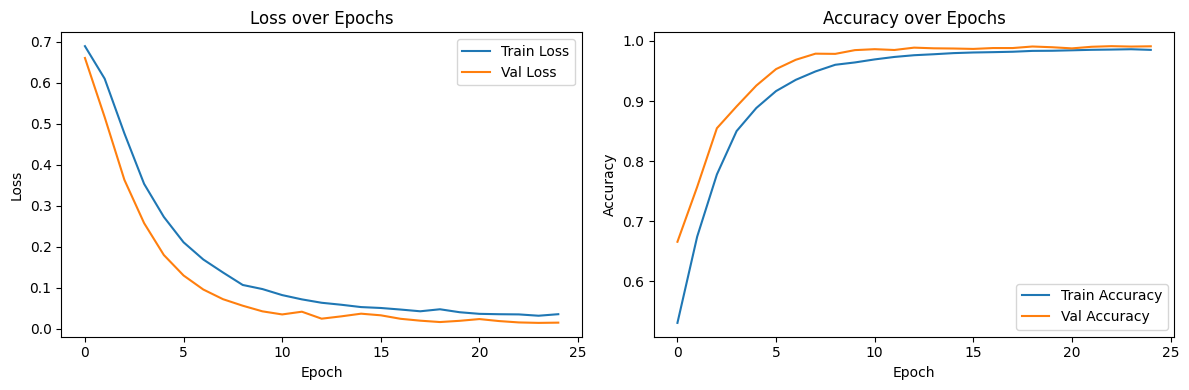

In [54]:
import matplotlib.pyplot as plt
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.savefig('training_validation_history.png')
plt.show()

In [55]:
# Initialize the model
model = CombinedModel(team_input_size, player_input_size, player_seq_len, ball_input_dim).to(device)

# Load the t20i model weights
model.load_state_dict(torch.load('t20i.pth',weights_only=True))

# Testing
model.eval()
test_correct_predictions = 0
test_total_predictions = 0
test_running_loss = 0.0
with torch.no_grad():
    for team_input, player_input, ball_input, labels, ball_lengths in test_dataloader:
        team_input, player_input, ball_input, labels = team_input.to(device), player_input.to(device), ball_input.to(device), labels.to(device)
        outputs = model(team_input, player_input, ball_input, ball_lengths)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item()

        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        test_correct_predictions += (predictions == labels).sum().item()
        test_total_predictions += labels.size(0)

test_avg_loss = test_running_loss / len(test_dataloader)
test_accuracy = test_correct_predictions / test_total_predictions
print(f"Test Loss: {test_avg_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0161, Test Accuracy: 0.9911
